# Seq2Seq Q&A Chatbot 구현

### 데이터 취득

In [1]:
import numpy as np
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/songys/Chatbot_data/refs/heads/master/ChatbotData.csv')
df = df[['Q', 'A']]
df

,Q,A
0,12시 땡!,하루가 또 가네요.
1,1지망 학교 떨어졌어,위로해 드립니다.
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.
4,PPL 심하네,눈살이 찌푸려지죠.
...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.
11820,흑기사 해주는 짝남.,설렜겠어요.
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.


In [2]:
df.to_csv('Seq2Seq_QA_Chatbot.txt', sep=',', index=False, header=False)

### 데이터 전처리

##### 토커나이저 학습 (sentencepiece 활용)

- 접두사, 접미사 처리 (bos, eos)

In [3]:
import sentencepiece as spt

input = 'Seq2Seq_QA_Chatbot.txt'
vocab_size = 10000
model_prefix = 'Seq2Seq_QA_Chatbot'
cmd = f'--input={input} --model_prefix={model_prefix} --vocab_size={vocab_size}'

spt.SentencePieceTrainer.Train(cmd)

##### 학습용 데이터 Q_input, A_input, A_target 생성

In [4]:
sp = spt.SentencePieceProcessor()
sp.Load(f'{model_prefix}.model')

input_Q = []
input_A = []
input_T = []

for text in df['Q']:
    token_id = sp.Encode(input=text, out_type=int, add_bos=True, add_eos=True)
    input_Q.append(token_id)

for text in df['A']:
    token_id_A = sp.Encode(input=text, out_type=int, add_bos=True)
    input_A.append(token_id)

    token_id_T = sp.Encode(input=text, out_type=int, add_eos=True)
    input_T.append(token_id_T)

print(input_Q)
print(input_A)
print(input_T)

[[1, 4650, 505, 3755, 71, 2], [1, 258, 8175, 838, 1591, 2], [1, 272, 1520, 2728, 81, 2606, 86, 2], [1, 272, 1520, 2728, 81, 585, 2606, 86, 2], [1, 5, 7283, 7283, 0, 5410, 2], [1, 8522, 7281, 3151, 3364, 675, 2], [1, 8522, 7281, 3151, 276, 2], [1, 2348, 764, 5372, 78, 4136, 1318, 2], [1, 2348, 5510, 27, 1674, 753, 100, 210, 2], [1, 2348, 5510, 180, 126, 3053, 5358, 2], [1, 2348, 840, 254, 1947, 17, 72, 5, 3295, 2], [1, 896, 677, 2], [1, 896, 3523, 19, 677, 2], [1, 896, 16, 4243, 14, 901, 2], [1, 98, 1024, 30, 394, 22, 2600, 1800, 2], [1, 3593, 93, 11, 2894, 3630, 2], [1, 98, 8573, 0, 4726, 1323, 4604, 2], [1, 3887, 2701, 4012, 17, 3865, 2], [1, 3887, 2701, 4012, 1321, 2150, 151, 56, 2], [1, 3887, 850, 25, 57, 34, 4074, 3, 2], [1, 3887, 850, 3323, 180, 1602, 5, 8251, 2], [1, 3887, 850, 1372, 3281, 2], [1, 639, 1436, 66, 480, 130, 2], [1, 1710, 354, 930, 52, 819, 2], [1, 1710, 354, 3526, 2], [1, 1710, 354, 405, 52, 475, 130, 2], [1, 1710, 93, 130, 2], [1, 1710, 1524, 3027, 630, 2], [1, 17

In [5]:
from tensorflow.keras.preprocessing.sequence import pad_sequences


max_len_Q = max([len(text) for text in input_Q])
max_len_A = max([len(text) for text in input_A])

input_Q_padded = pad_sequences(input_Q, maxlen=max_len_Q, padding='pre')
input_A_padded = pad_sequences(input_A, maxlen=max_len_A, padding='post')
input_T_padded = pad_sequences(input_T, maxlen=max_len_A, padding='post')

print(input_Q[:5])
print(input_A[:5])
print(input_T[:5])

[[1, 4650, 505, 3755, 71, 2], [1, 258, 8175, 838, 1591, 2], [1, 272, 1520, 2728, 81, 2606, 86, 2], [1, 272, 1520, 2728, 81, 585, 2606, 86, 2], [1, 5, 7283, 7283, 0, 5410, 2]]
[[1, 1780, 2448, 1085, 2], [1, 1780, 2448, 1085, 2], [1, 1780, 2448, 1085, 2], [1, 1780, 2448, 1085, 2], [1, 1780, 2448, 1085, 2]]
[[293, 8, 114, 98, 24, 3, 2], [1617, 5, 3861, 3, 2], [354, 16, 369, 53, 176, 3, 2], [354, 16, 369, 53, 176, 3, 2], [280, 560, 12, 2542, 3625, 8730, 37, 3, 2]]


### 모델 생성 및 학습

##### 인코더 생성

In [6]:
from tensorflow.keras import layers, models

EMBEDDING_DIM = 100
LATENT_DIM = 512
WORD_NUM = min(vocab_size, sp.GetPieceSize())

encoder_inputs = layers.Input(shape=(max_len_Q,))
en_embedding_layer = layers.Embedding(WORD_NUM+1, EMBEDDING_DIM)
x = en_embedding_layer(encoder_inputs)
encoder_outputs, h, c = layers.LSTM(LATENT_DIM, return_state=True)(x)
encoder_states = [h, c]

encoder_model = models.Model(inputs=encoder_inputs, outputs=encoder_states)
encoder_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 26)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 26, 100)        │     1,000,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ [(None, 512), (None,   │     1,255,424 │
│                                 │ 512), (None, 512)]     │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,255,524 (8.60 MB)

 Trainable params: 2,255,524 (8.60 MB)

 Non-trainable params: 0 (0.00 B)

##### 디코더(teacher-forcing 모델) 생성

In [7]:
decoder_inputs = layers.Input(shape=(max_len_A,))
input_A_embedding_layer = layers.Embedding(WORD_NUM+1, EMBEDDING_DIM)
x = input_A_embedding_layer(decoder_inputs)

decoder_lstm = layers.LSTM(LATENT_DIM, return_sequences=True, return_state=True)
x, h, c = decoder_lstm(x, initial_state=encoder_states)

decoder_dense = layers.Dense(WORD_NUM+1, activation='softmax')
decoder_outputs = decoder_dense(x)

decoder_teacher_forcing_model = models.Model(
    inputs=[encoder_inputs, decoder_inputs],
    outputs=decoder_outputs
)

decoder_teacher_forcing_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 26)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 26, 100)   │  1,000,100 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 5, 100)    │  1,000,100 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 512),     │  1,255,424 │ embedding[0][0]   │
│                     │ (None, 512),      │            │                   │
│                     │ (None, 512)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 5, 512),  │  1,255,424 │ embedding_1[0][0… │
│                     │ (None, 512),      │            │ lstm[0][1],       │
│                     │ (None, 512)]      │            │ lstm[0][2]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 5, 10001)  │  5,130,513 │ lstm_1[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,641,561 (36.78 MB)

 Trainable params: 9,641,561 (36.78 MB)

 Non-trainable params: 0 (0.00 B)

##### 학습

In [8]:
decoder_teacher_forcing_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

history = decoder_teacher_forcing_model.fit(
    [input_Q_padded, input_A_padded],
    input_T_padded,
    batch_size=64,
    epochs=100,
    validation_split=0.2
)

Epoch 1/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.3368 - loss: 5.4131 - val_accuracy: 0.4205 - val_loss: 3.8686
Epoch 2/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.4099 - loss: 3.6900 - val_accuracy: 0.4217 - val_loss: 3.8459
Epoch 3/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.4133 - loss: 3.6049 - val_accuracy: 0.4260 - val_loss: 3.8512
Epoch 4/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.4078 - loss: 3.5962 - val_accuracy: 0.4190 - val_loss: 3.8649
Epoch 5/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.4120 - loss: 3.5600 - val_accuracy: 0.4192 - val_loss: 3.8885
Epoch 6/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.4127 - loss: 3.5119 - val_accuracy: 0.4158 - val_loss: 3.9290
Epoch 7/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.4221 - loss: 3.4400 - val_accuracy: 0.4076 - val_loss: 3.9371
Epoch 8/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.4288 - loss: 3.4011 - 

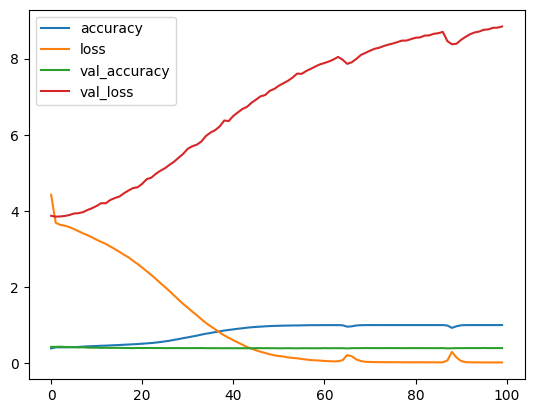

In [9]:
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot()
plt.show()

In [10]:
decoder_teacher_forcing_model.save('decoder_teacher_forcing_model.keras')

In [11]:
from tensorflow.keras.models import load_model
decoder_teacher_forcing_model = load_model('decoder_teacher_forcing_model.keras')

### 모델 추론

##### 디코더(추론 모델) 생성

In [12]:
decoder_hidden_state = layers.Input(shape=(LATENT_DIM,))
decoder_cell_state = layers.Input(shape=(LATENT_DIM,))
decoder_states_inputs = [decoder_hidden_state, decoder_cell_state]

decoder_single_input = layers.Input(shape=(1,))

x = input_A_embedding_layer(decoder_single_input)

x, h, c = decoder_lstm(x, initial_state=decoder_states_inputs)
decoder_states = [h, c]

decoder_outputs_ = decoder_dense(x)

decoder_inference_model = models.Model(
    inputs=[decoder_single_input] + decoder_states_inputs,
    outputs=[decoder_outputs_] + decoder_states
)
decoder_inference_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 100)    │  1,000,100 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 512)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 512)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 1, 512),  │  1,255,424 │ embedding_1[1][0… │
│                     │ (None, 512),      │            │ input_layer_2[0]… │
│                     │ (None, 512)]      │            │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1, 10001)  │  5,130,513 │ lstm_1[1][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,386,037 (28.18 MB)

 Trainable params: 7,386,037 (28.18 MB)

 Non-trainable params: 0 (0.00 B)

##### 추론 함수

In [13]:
def QuestionAnswer(input_seq):
    """
    input_seq: shape (1, max_len_Q) 의 패딩된 질문 토큰 시퀀스 (int ids)
    반환: 디코더가 생성한 문장 (str)
    """
    import numpy as np

    # 1) 인코더로 초기 상태 얻기
    states_value = encoder_model.predict(input_seq, verbose=0)

    # 2) 디코더 시작 토큰 준비 (SentencePiece BOS)
    start_id = sp.bos_id()
    end_id = sp.eos_id()
    decoder_input = np.array([[start_id]], dtype="int32")  # (1,1)

    # 3) 토큰을 하나씩 생성
    decoded_ids = []
    for _ in range(int(max_len_A)):  # 최대 답변 길이만큼
        # decoder_inference_model:
        #   inputs=[decoder_single_input] + [h, c]
        #   outputs=[token_dists] + [h, c]
        token_dists, h, c = decoder_inference_model.predict(
            [decoder_input] + states_value, verbose=0
        )

        # 가장 확률 높은 토큰 선택 (greedy)
        sampled_token_id = int(np.argmax(token_dists[0, -1, :]))

        # 종료 토큰이면 중단
        if sampled_token_id == end_id:
            break

        decoded_ids.append(sampled_token_id)

        # 다음 스텝 입력 & 상태 업데이트
        decoder_input = np.array([[sampled_token_id]], dtype="int32")
        states_value = [h, c]

    # 4) 토큰 id → 문장
    try:
        return sp.DecodeIds(decoded_ids)
    except Exception:
        # 혹시 토큰 범위 문제 등으로 디코딩 실패 시 안전 처리
        return sp.DecodePieces([sp.IdToPiece(t) for t in decoded_ids])


def ids_to_text(token_ids):
    # numpy → 파이썬 int로 확실히 변환
    ids = token_ids
    if isinstance(ids, np.ndarray):
        ids = ids.tolist()
    ids = [int(t) for t in ids]

    # PAD 제거 (보통 0)
    PAD = 0
    ids = [t for t in ids if t != PAD]

    # BOS/EOS 제거 (SentencePiece)
    bos = int(sp.bos_id())
    eos = int(sp.eos_id())
    if ids and ids[0] == bos:
        ids = ids[1:]
    if ids and ids[-1] == eos:
        ids = ids[:-1]

    # 빈 리스트면 바로 반환
    if not ids:
        return ""

    # 디코딩
    try:
        return sp.DecodeIds(ids)          # 정석 경로
    except Exception:
        # 예외시 piece 경로로 안전 복원
        pieces = [sp.IdToPiece(int(t)) for t in ids]
        return sp.DecodePieces(pieces)

##### 테스트

In [14]:
print(input_Q[:1])

input_seq = input_Q_padded[:1]
QuestionAnswer(input_seq)

[[1, 4650, 505, 3755, 71, 2]]


'또 가네요네요네요'

In [15]:
import numpy as np

for _ in range(5):
    idx = np.random.randint(len(input_Q_padded))
    input_seq = input_Q_padded[idx:idx+1]
    output_sent = QuestionAnswer(input_seq)

    input_ids  = input_Q_padded[idx]
    target_ids = input_A_padded[idx] if 'input_A_padded' in globals() else None

    print("질문을 입력하세요: " + ids_to_text(input_ids))
    if target_ids is not None:
        print("학습한 답변: " + ids_to_text(target_ids))
    print("추론한 답변: " + output_sent)
    print("---------------------------------")

질문을 입력하세요: 마음도 춥고 날씨도 춥네
학습한 답변: 힘들어서 결혼할까봐
추론한 답변: 마음 감기조심하세요요.
---------------------------------
질문을 입력하세요: 전여친이 나보다 나은 사람이라는 생각이 자꾸 들어
학습한 답변: 힘들어서 결혼할까봐
추론한 답변: 더 사랑 사랑보세요보세요
---------------------------------
질문을 입력하세요: 잠시라도 좋으니 만낳 수 있을까
학습한 답변: 힘들어서 결혼할까봐
추론한 답변: 있다면 연락해보세요해보세요.
---------------------------------
질문을 입력하세요: 월급이 안 오르네
학습한 답변: 힘들어서 결혼할까봐
추론한 답변: 게 말씀해보세요해보세요.
---------------------------------
질문을 입력하세요: 장 봤는데 다 비싸
학습한 답변: 힘들어서 결혼할까봐
추론한 답변: 가 많이 많이 많이 비싸
---------------------------------


### 간단한 Chatbot 구현

1. 사용자의 입력을 받아 (데이터 처리)
2. 추론 함수에 전달해서
3. 응답을 출력
4. 1~3을 '종료' 전까지 반복

In [16]:
def preprocess_input(text):
    token_ids = sp.Encode(input=text, out_type=int, add_bos=True, add_eos=True)
    padded_input = pad_sequences([token_ids], maxlen=max_len_Q, padding='pre')
    return padded_input

In [19]:
if 'input' in globals():
    del input

In [34]:
print("챗봇과 대화하세요 ('종료'를 입력하면 종료됩니다.)")

while True:
    user_input_text = input("질문: ")
    if user_input_text == '종료':
        print("챗봇을 종료합니다.")
        break

    processed_input = preprocess_input(user_input_text)
    response_ids = QuestionAnswer(processed_input)
    print("답변: " + response_ids)

챗봇과 대화하세요 ('종료'를 입력하면 종료됩니다.)
질문: 안녕
답변: 안녕하세요.
질문: 너 머해?
답변: 네 말씀하세요.
질문: 나 살찐 것 같아?
답변: 일 것 같아요..
질문: 맞아. 다이어트 실패했어.
답변: 아시네요네요네요
질문: 너 누구야?
답변: 위로봇 거예요 거예요 것
질문: 사실 나도 인공지능이야.
답변: 연락하지 말아요.
질문: 종료
챗봇을 종료합니다.
